In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

## Parameters

In [12]:
dicLagged={"_X12":12,
           "_X24":24,
           "_Y12":-12,
           "_Y24":-24}


## Loading data

In [13]:
train_data=pd.read_csv('data/TrainData3.csv')
test_data=pd.read_csv('data/TargetData3.csv')
train_data.head()

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 00:00,NaN,NaN,NaN,NaN,NaN
1,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
2,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768
3,20150101 03:00,0.666693,5.99531,4.89334,9.52143,6.99094
4,20150101 04:00,NaN,6.90809,4.79099,10.63280,6.75417


In [14]:
train_data.describe()

,POWER,U10,V10,U100,V100
count,26590.000000,27048.000000,27048.000000,27048.000000,27048.000000
mean,0.519677,2.286938,0.700514,3.124931,1.051055
std,0.313106,5.100936,4.481148,7.018101,6.150222
min,0.000000,-11.649200,-18.724500,-15.922300,-25.071400
25%,0.232298,-1.747315,-2.539780,-2.175257,-3.433463
50%,0.541332,2.788535,0.745344,3.923615,1.024665
75%,0.812216,6.047033,3.814062,8.239865,5.320432
max,1.000000,21.876300,18.122800,31.050900,25.117400


## Preprocessing

In [15]:
train_data['TIMESTAMP']=pd.to_datetime(train_data['TIMESTAMP'],format="%Y%m%d %H:%M")

In [16]:
train_data['WS10']=[sqrt(train_data['U10'][i]**2+train_data['V10'][i]**2) for i in range(len(train_data['U10']))]
train_data['WS100']=[sqrt(train_data['U100'][i]**2+train_data['V100'][i]**2) for i in range(len(train_data['U100']))]
train_data['WS']=[np.interp(70, [10,100], [train_data['WS10'][i],train_data['WS100'][i]]) for i in range(len(train_data['WS10']))]

In [17]:
train_data=train_data.set_index("TIMESTAMP")

### Inputing with interpolation

In [18]:
train_data['FillInterp']=train_data['POWER'].interpolate(method="time")

In [19]:
train_data = train_data.assign(MISSING= np.nan)
train_data.MISSING[train_data.POWER.isna()] = train_data.FillInterp

In [20]:
train_data.head()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING
TIMESTAMP,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,NaN,6.24102,3.49613,9.73707,4.78492,7.153548,10.849239,9.617342,NaN,NaN
2015-01-01 02:00:00,NaN,5.62234,4.06239,8.94497,5.71768,6.936405,10.616231,9.389622,NaN,NaN
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,7.738767,11.812319,10.454468,0.666693,NaN
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,8.406860,12.596636,11.200044,0.756962,0.756962


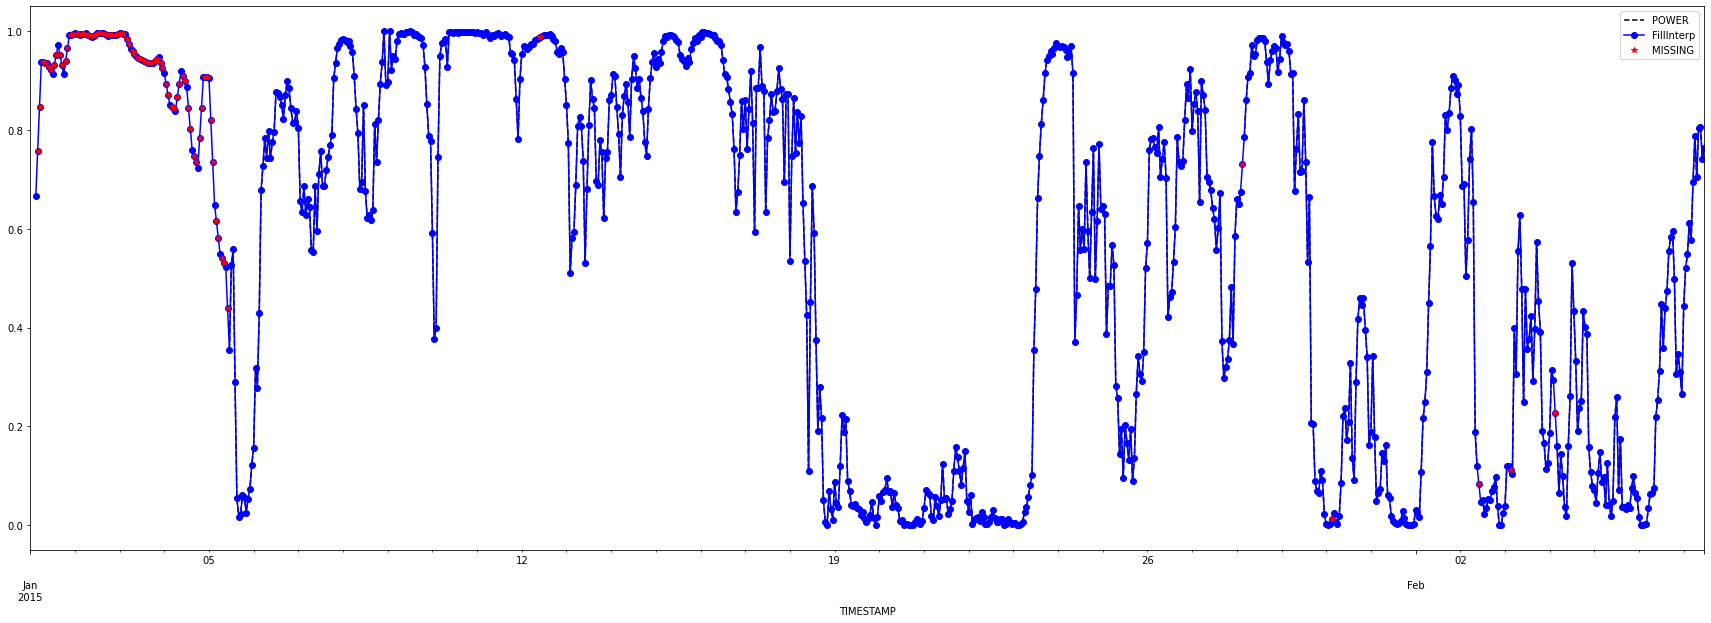

In [21]:
train_data[['POWER','FillInterp','MISSING']].head(900).plot(style=['k--', 'bo-', 'r*'], figsize=(30, 10))
plt.show()

### Inputing with mean/median

In [22]:
#Use assign to avoid pandas warning
train_data = train_data.assign(FillMean=train_data.POWER.fillna(train_data.POWER.mean()))
train_data = train_data.assign(FillMedian=train_data.POWER.fillna(train_data.POWER.median()))

In [23]:
train_data.head()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING,FillMean,FillMedian
TIMESTAMP,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.519677,0.541332
2015-01-01 01:00:00,NaN,6.24102,3.49613,9.73707,4.78492,7.153548,10.849239,9.617342,NaN,NaN,0.519677,0.541332
2015-01-01 02:00:00,NaN,5.62234,4.06239,8.94497,5.71768,6.936405,10.616231,9.389622,NaN,NaN,0.519677,0.541332
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,7.738767,11.812319,10.454468,0.666693,NaN,0.666693,0.666693
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,8.406860,12.596636,11.200044,0.756962,0.756962,0.519677,0.541332


### Inputing with rolling mean/median

In [24]:
train_data = train_data.assign(FillRollingMean=train_data.POWER.fillna(train_data.POWER.rolling(24,min_periods=1).mean()))
train_data = train_data.assign(FillRollingMedian=train_data.POWER.fillna(train_data.POWER.rolling(24,min_periods=1).median()))

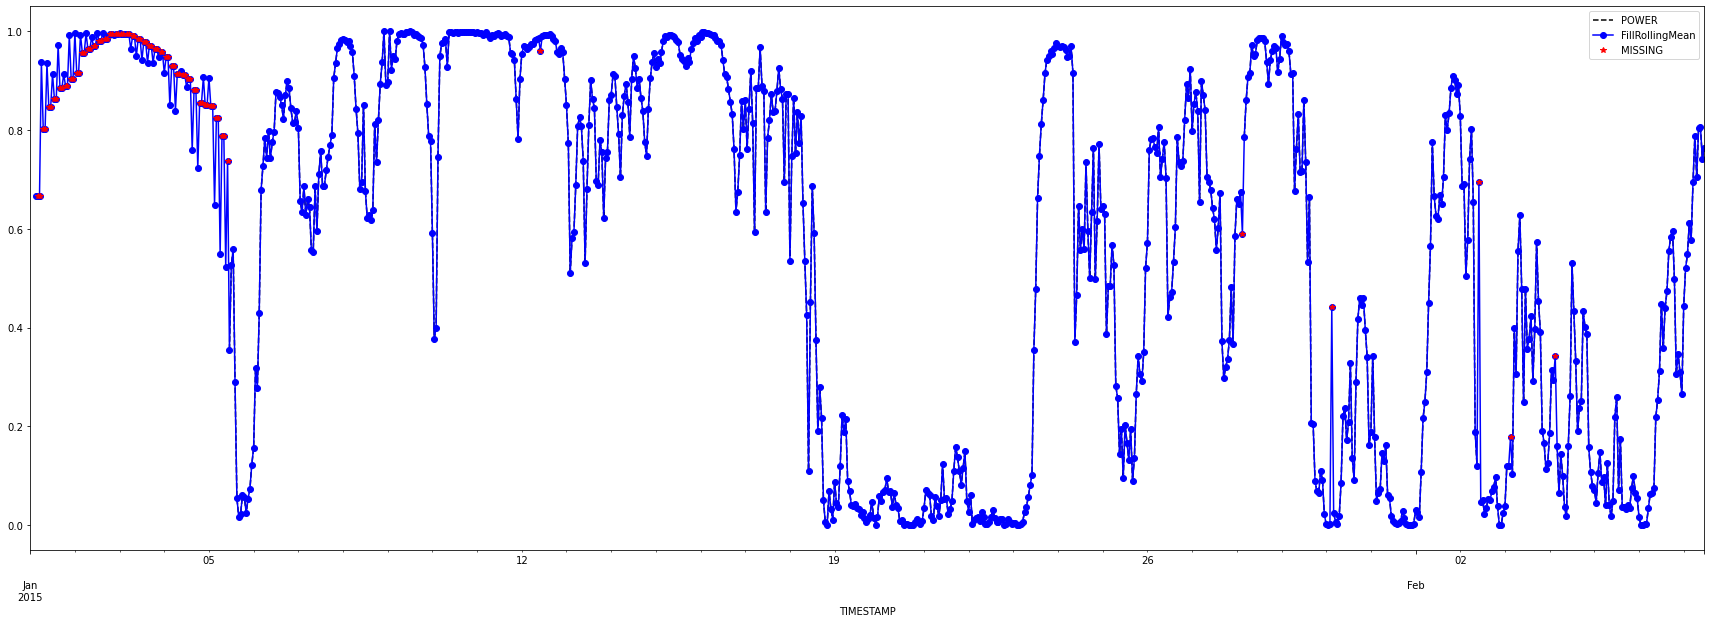

In [25]:
train_data = train_data.assign(MISSING= np.nan)
train_data.MISSING[train_data.POWER.isna()] = train_data.FillRollingMean
train_data[['POWER','FillRollingMean','MISSING']].head(900).plot(style=['k--', 'bo-', 'r*'], figsize=(30, 10))
plt.show()

### Seasonality

In [26]:
target_column="FillInterp"
df=train_data.dropna(subset=[target_column])

In [27]:
df.describe()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING,FillMean,FillMedian,FillRollingMean,FillRollingMedian
count,26590.000000,27046.000000,27046.000000,27046.000000,27046.000000,27046.000000,27046.000000,27046.000000,27046.000000,308.000000,27046.000000,27046.000000,26898.000000,26898.000000
mean,0.519677,2.286668,0.700286,3.124472,1.050744,6.553776,9.012821,8.193139,0.518423,0.596540,0.519677,0.520042,0.520557,0.520749
std,0.313106,5.101027,4.481235,7.018156,6.150342,2.977892,4.088284,3.702120,0.313312,0.274153,0.310456,0.310468,0.312790,0.313018
min,0.000000,-11.649200,-18.724500,-15.922300,-25.071400,0.025588,0.036808,0.076573,0.000000,0.033619,0.000000,0.000000,0.000000,0.000000
25%,0.232298,-1.747785,-2.540160,-2.176432,-3.433827,4.371342,6.095957,5.518060,0.228891,0.440346,0.237995,0.237995,0.233756,0.233601
50%,0.541332,2.788240,0.745165,3.923315,1.024160,6.306697,8.679780,7.886960,0.538451,0.637724,0.531528,0.541332,0.542462,0.542955
75%,0.812216,6.046895,3.813817,8.238608,5.320052,8.456463,11.541833,10.511541,0.811563,0.835200,0.807999,0.807999,0.812390,0.812521
max,1.000000,21.876300,18.122800,31.050900,25.117400,22.269912,31.450741,28.377922,1.000000,0.993474,1.000000,1.000000,1.000000,1.000000


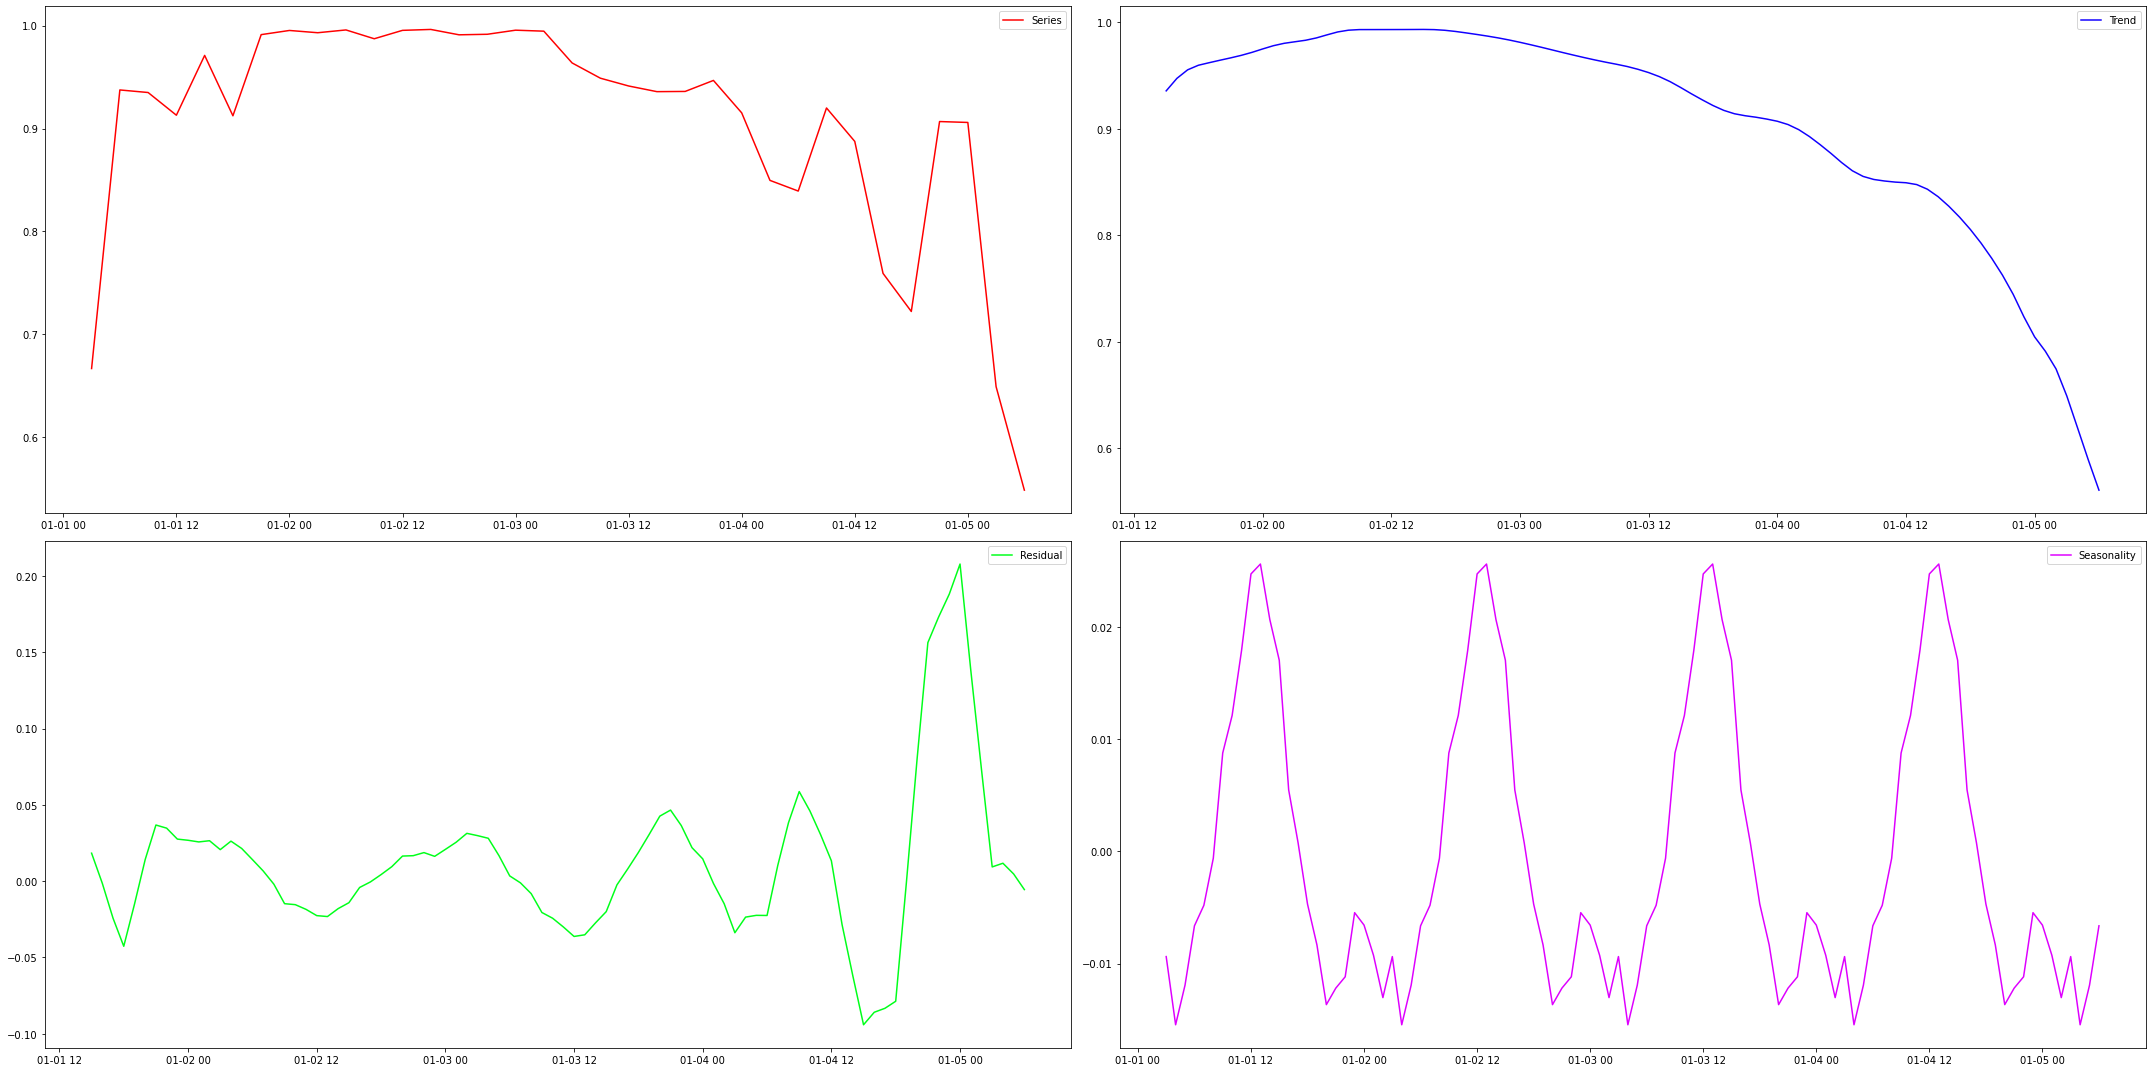

In [28]:
series=df[target_column]
decomposition=seasonal_decompose(series, model='additive')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
thresh=100
plt.figure(figsize=(30,15))
plt.subplot(221)
plt.plot(series.iloc[:100],color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend.iloc[:100],color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual.iloc[:100],color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal.iloc[:100],color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Autocorrelation

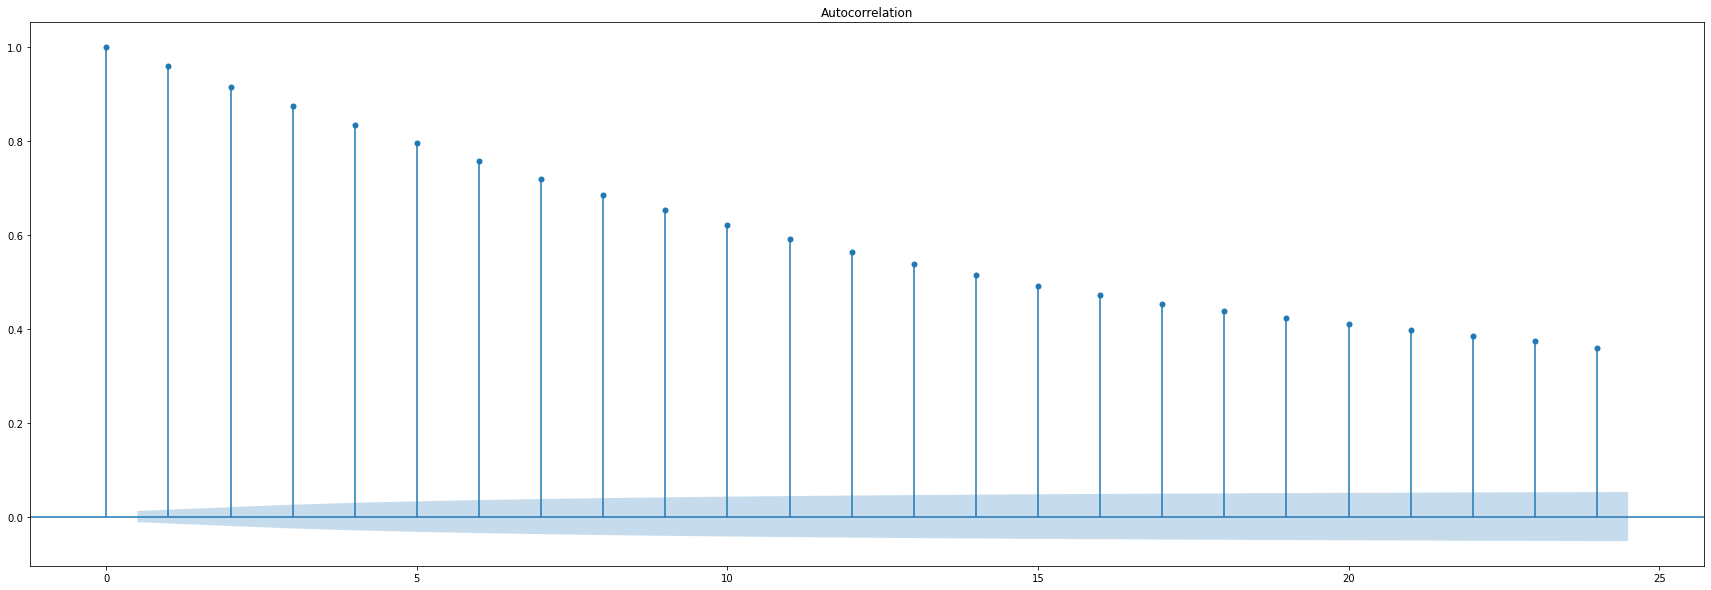

In [29]:
series=df[target_column]
fig, ax = plt.subplots(figsize=(30, 10))
fig=plot_acf(series,lags=24,ax=ax)
plt.show()

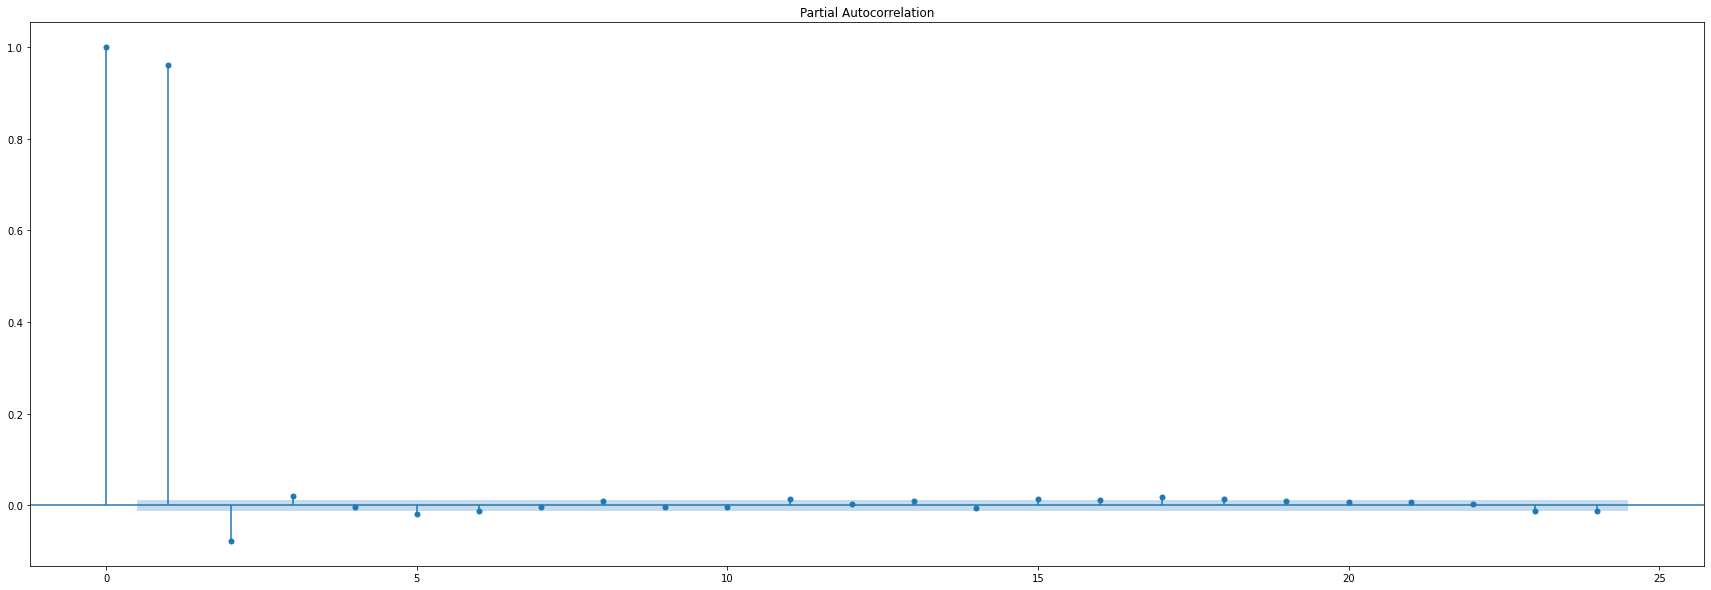

In [30]:
fig, ax = plt.subplots(figsize=(30, 10))
fig=plot_pacf(series,lags=24,ax=ax)
plt.show()

## Compute lagged values

In [31]:
for col, window in dicLagged.items():
    df[target_column+col]=df[target_column].rolling(abs(window)).mean().shift(window)


In [32]:
df.head()

,POWER,U10,V10,U100,V100,WS10,WS100,WS,FillInterp,MISSING,FillMean,FillMedian,FillRollingMean,FillRollingMedian,FillInterp_X12,FillInterp_X24,FillInterp_Y12,FillInterp_Y24
TIMESTAMP,,,,,,,,,,,,,,,,,,
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,7.738767,11.812319,10.454468,0.666693,NaN,0.666693,0.666693,0.666693,0.666693,NaN,NaN,0.913765,0.942477
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,8.406860,12.596636,11.200044,0.756962,0.666693,0.519677,0.541332,0.666693,0.666693,NaN,NaN,0.929978,0.952354
2015-01-01 05:00:00,NaN,6.95268,4.83204,10.70080,6.74193,8.466898,12.647559,11.254005,0.847231,0.666693,0.519677,0.541332,0.666693,0.666693,NaN,NaN,0.937037,0.958508
2015-01-01 06:00:00,0.937501,6.17865,5.70277,9.73491,8.09731,8.408169,12.662342,11.244284,0.937501,NaN,0.937501,0.937501,0.937501,0.937501,NaN,NaN,0.934944,0.960939
2015-01-01 07:00:00,NaN,7.63436,4.76415,11.73130,6.60519,8.998921,13.462984,11.974963,0.936668,0.802097,0.519677,0.541332,0.802097,0.802097,NaN,NaN,0.935111,0.963285


In [33]:
#diff_series=(series-series.shift(1)).dropna()
y = series.values
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Lags used: %f' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.413598
p-value: 0.000000
Lags used: 24.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Fitting model

In [37]:
X=df["WS"].values.reshape(-1,1)
tscv = TimeSeriesSplit(n_splits=3)
errors=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mdl=SARIMAX(y_train, exog=X_train, order=(1,0,0), seasonal_order=(0,0,0,24),
                enforce_stationarity=True, enforce_invertibility=False).fit()
    y_pred=mdl.predict(start =test_index[0], end=test_index[-1],exog=X_test)
    mse=mean_squared_error(y_test,y_pred)
    errors.append(mse)
    
print ('Generalization Error: ', np.mean(errors))

Generalization Error:  0.1288492273566705


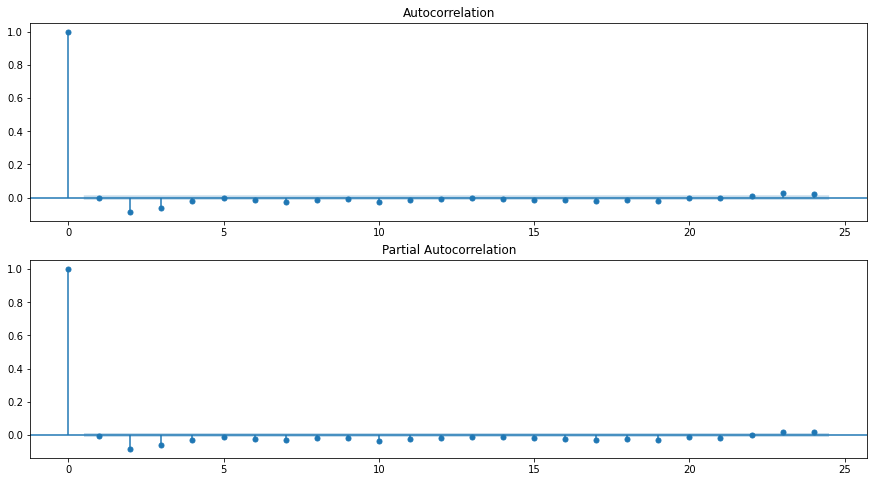

In [36]:
res = mdl.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(res, lags=24, ax=ax[0])
fig = plot_pacf(res, lags=24, ax=ax[1])
plt.show()

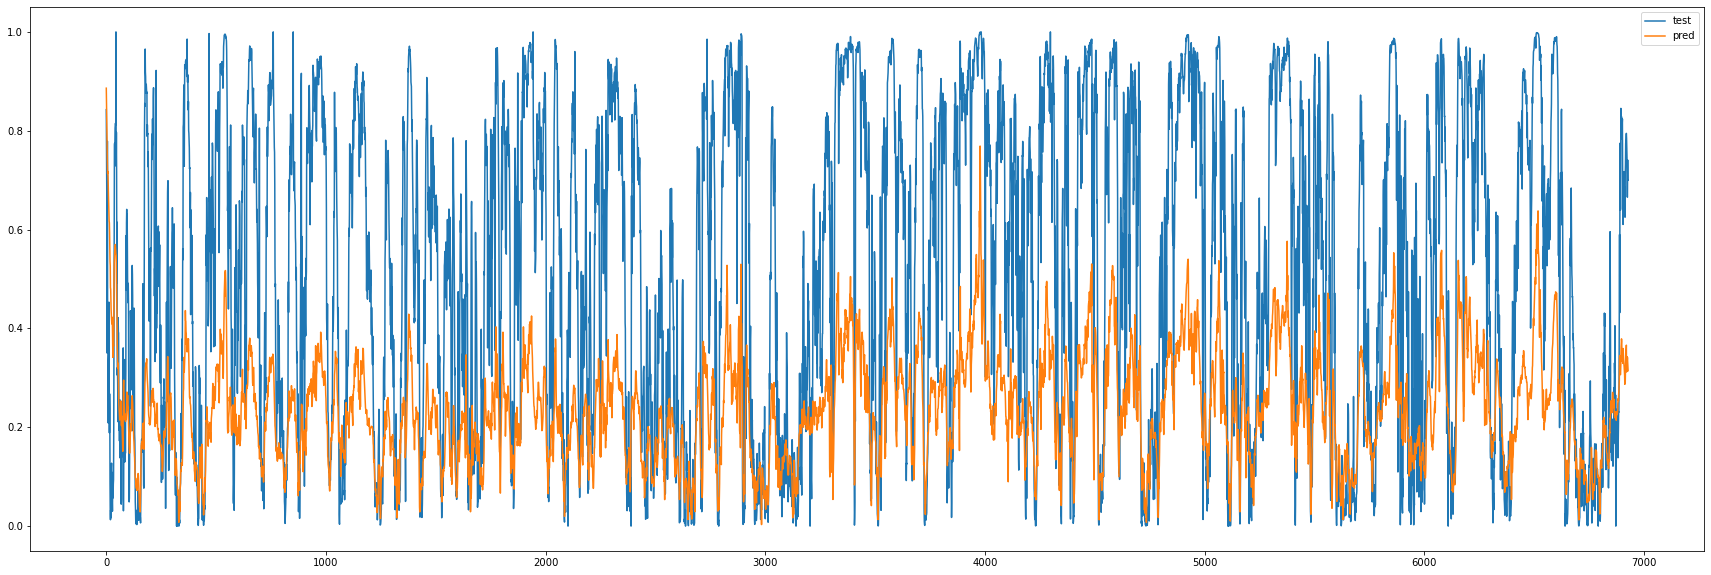

In [26]:
pd.DataFrame({'test':y_test,'pred':y_pred}).plot(figsize=(30,10))
plt.show()

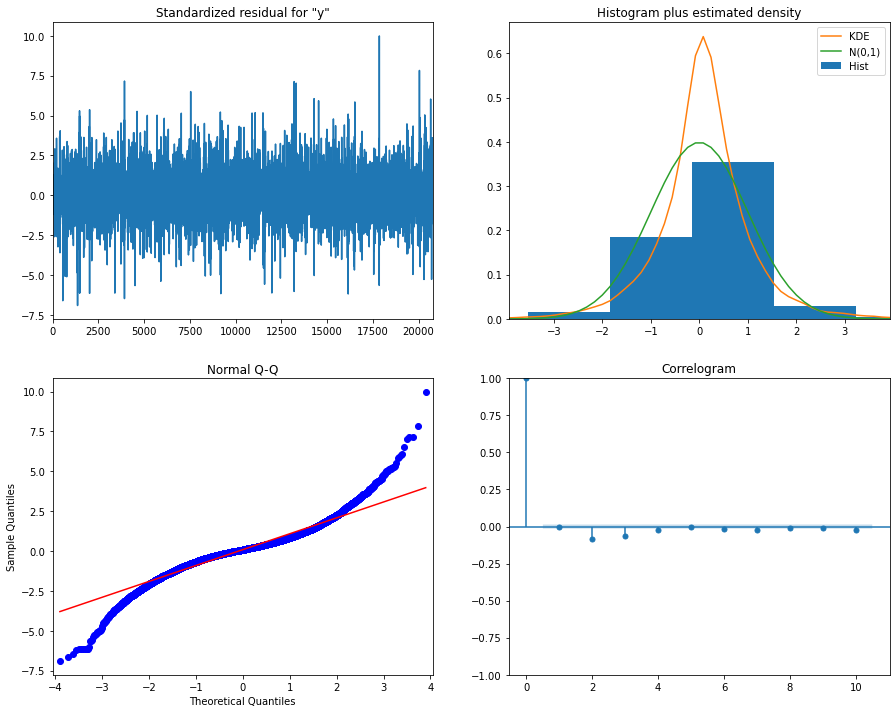

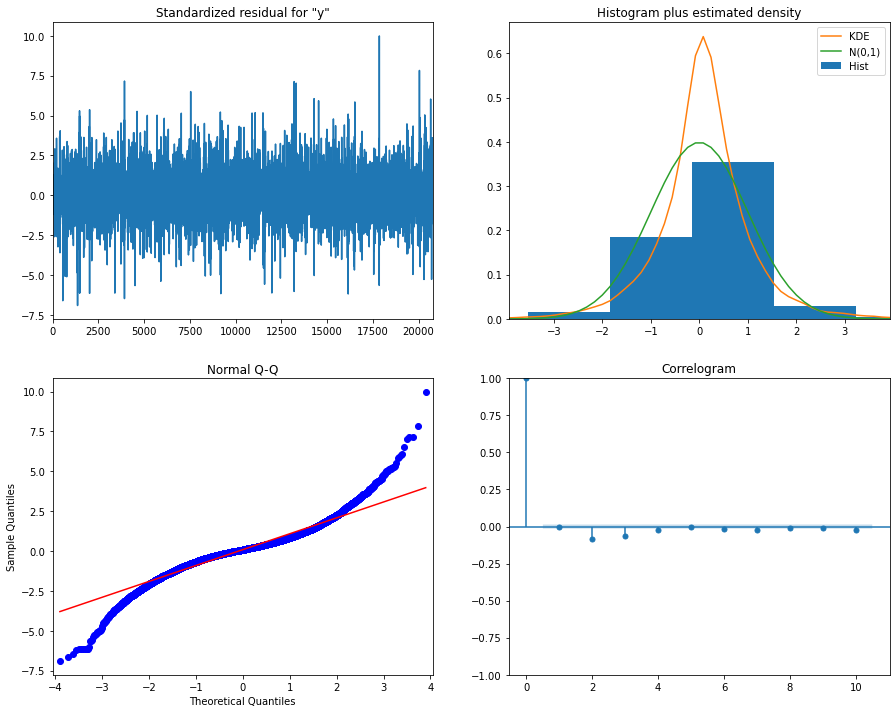

In [27]:
mdl.plot_diagnostics(figsize=(15, 12))

**Some Obversations**

* The QQ plots will show us if our series is normally distributed by plotting its distribution against normally distributed series. It seems that there is quite a bit of deviation, which implies skewness in our data (also shown in the histogram plot)
* Our model is clearly not the most accurate

### Modeling with Facebook Prophet

In [28]:
from fbprophet import Prophet

In [29]:
#data=series.reset_index()
#data.rename(columns={"TIMESTAMP":"ds",target_column:"y"},inplace=True)

In [30]:
data=series.reset_index()
data.rename(columns={"TIMESTAMP":"ds",target_column:"y"},inplace=True)

In [31]:
data.shape

(27718, 2)

In [32]:
#model=Prophet(interval_width=0.8,seasonality_mode="additive")
#model.add_seasonality(name='dailyy', period=24, fourier_order=3)
model=Prophet()

In [33]:
#model.fit(data)

In [34]:
data

,ds,y
0,2015-01-01 03:00:00,0.666693
1,2015-01-01 04:00:00,0.756962
2,2015-01-01 05:00:00,0.847231
3,2015-01-01 06:00:00,0.937501
4,2015-01-01 07:00:00,0.936668
...,...,...
27713,2018-02-28 20:00:00,0.666377
27714,2018-02-28 21:00:00,0.665494
27715,2018-02-28 22:00:00,0.740842
27716,2018-02-28 23:00:00,0.699803
